ルートディレクトリに移動

In [2]:
%cd ../..

E:\システムトレード入門\trade_system_git_workspace


# 強化学習で株取引　その１ 

今回は環境の作成もかねて，一つの銘柄の取引を強化学習で行う．予測とはアルゴリズムを分離するため，未来の株価も含めるように調整する．

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy.random import RandomState
import pandas as pd
from tqdm.notebook import tqdm
from collections import namedtuple
import collections
from copy import deepcopy
import matplotlib.pyplot as plt

In [4]:
import gym
from gym import spaces, logger
from gym.utils import seeding

In [5]:
import datetime
from pytz import timezone

In [6]:
from pathlib import Path

In [7]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [8]:
import pfrl

In [9]:
from get_stock_price import StockDatabase

In [12]:
from utils import middle_sample_type_with_check, get_previous_datetime
from utils import py_workdays
from py_workdays import extract_workdays_intraday_jp_index, extract_workdays_intraday_jp, get_next_workday_jp

In [13]:
from utils import py_restart

In [14]:
from visualize_trading_process_ver2 import plot_trading_process_matplotlib, plot_trading_process_bokeh

### データベース 

In [15]:
db_path = Path("E:/システムトレード入門/trade_system_git_workspace/db/sub_stock_db") / Path("sub_stock.db")
stock_db = StockDatabase(db_path)

In [16]:
stock_list = ["4755","9984","6701","7203","7267"]
stock_db.stock_in(stock_list)

array([ True,  True,  True,  True,  True])

In [18]:
stock_db.stock_timestamp(stock_list)

,min_datetime,max_datetime,column_name
0,2020-11-02 00:00:00+00:00,2020-11-30 14:59:00+00:00,4755
1,2020-11-02 00:00:00+00:00,2020-11-30 14:59:00+00:00,9984
2,2020-11-02 00:00:00+00:00,2020-11-30 14:59:00+00:00,6701
3,2020-11-02 00:00:00+00:00,2020-11-30 14:59:00+00:00,7203
4,2020-11-02 00:00:00+00:00,2020-11-30 14:59:00+00:00,7267


### 利用するデータ

In [19]:
jst_timezone = timezone("Asia/Tokyo")
start_datetime = jst_timezone.localize(datetime.datetime(2020,11,10,0,0,0))
end_datetime = jst_timezone.localize(datetime.datetime(2020,11,20,0,0,0))
#end_datetime = get_next_workday_jp(start_datetime, days=11)  # 営業日で一週間(5日間)

#stock_names = "4755"
#stock_names = "9984"
stock_names = "6502"
#stock_names = ["6502","4755"]
#stock_list = ["4755","9984","6701","7203","7267"]

stock_df = stock_db.search_span(stock_names=stock_names, 
                                start_datetime=start_datetime,
                                end_datetime=end_datetime,
                                freq_str="T",
                                to_tokyo=True
                               )

use_ohlc="Close"

#### 利用するデータの描画 

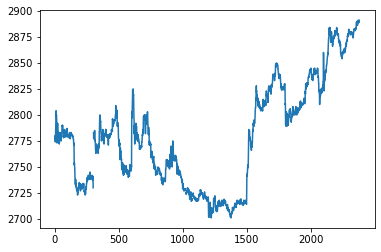

In [20]:
if isinstance(stock_names, str):
    stock_names = [stock_names]

for stock_name in stock_names:
    fig, ax=plt.subplots()
    column_name = use_ohlc + "_" + stock_name
    intraday_stock_df = extract_workdays_intraday_jp(stock_df)
    stock_price_array = intraday_stock_df.loc[:,column_name].copy().values
    x = np.arange(0,len(stock_price_array))
    ax.plot(x,stock_price_array)

### 環境クラス 

#### 状態クラス (namedtuple)

In [17]:
field_list = ["cash", "unit_number", "mean_cost_price", "all_property", "price_array"]
StockStateBase = namedtuple("StockStateBase", field_list)

class StockState(StockStateBase):
    def to_numpy(self):
        """
        ndarrayに変更する．最後に利用するのがいい？
        """
        cash_unit_mean_all_array = np.array([self.cash, self.unit_number, self.mean_cost_price, self.all_property])
        return np.concatenate([cash_unit_mean_all_array, self.price_array.copy()], axis=0)  # コピーすることに注意
    
    @classmethod
    def from_numpy(cls, stock_state_array):
        """
        ndarrayからこのクラスを作成する．基本的に使わない．
        """
        cash = stock_state_array[0]
        unit_number = stock_state_array[1]
        mean_cost_price = stock_state_array[2]
        all_property = stock_state_array[3]
        price_array = stock_state_array[4:]
        
        return cls(cash=cash, unit_number=unit_number, mean_cost_price=mean_cost_price, all_property=all_property, price_array=price_array)

    def copy(self):
        """
        deepcopyでもいいが，一応明示しておく
        """
        new_state = StockState(cash=self.cash,
                               unit_number=self.unit_number,
                               mean_cost_price=self.mean_cost_price,
                               all_property=self.all_property,
                               price_array=self.price_array.copy())
        return new_state
    
    @property
    def now_price(self):
        return self.price_array[0]

#### 前処理用のクラス 

Stateを変換するためのクラス．

In [18]:
class NormalizeState():
    def __init__(self, cash_const=1, unit_const=1, price_const=1, all_property_const=1):
        self.cash_devide_const = cash_const
        self.unit_devide_const = unit_const
        self.price_devide_const = price_const
        self.all_property_const = all_property_const
        
    def __call__(self, state):
        # cash
        cash = state.cash / self.cash_devide_const
        # unit_number
        unit_number = state.unit_number / self.unit_devide_const
        # price_array
        mean_cost_price = state.mean_cost_price / self.price_devide_const
        price_array = state.price_array / self.price_devide_const
        # all_property
        all_property = state.all_property / self.all_property_const
        
        new_state = state._replace(cash=cash, 
                                   unit_number=unit_number, 
                                   mean_cost_price=mean_cost_price,
                                   all_property=all_property,
                                   price_array=price_array)  # 新しいオブジェクト 
        
        return new_state

class NormalizeReward():
    def __init__(self, reward_const=1):
        self.reward_devide_const = reward_const
        
    def __call__(self, reward):
        reward = reward / self.reward_devide_const
        
        return reward

#### サンプリングのためのクラス

In [19]:
class WindowSampler():
    def __init__(self, stock_names, start_datetime, end_datetime, freq_str, end_include=False):
        """
        指定した範囲から，エピソード分利用可能なdatetimeをサンプリングするためのクラス
        """
        if isinstance(stock_names, str):  # 銘柄コードが一つの場合
            stock_names = [stock_names]
        self.stock_names = stock_names
        
        self.start_datetime = start_datetime
        self.end_datetime = end_datetime
        # タイムゾーンが同じかチェック
        if self.start_datetime.tzinfo != self.end_datetime.tzinfo:
            raise Exception("The timezone of start_datetime and end_datetime must be same")
        
        self.freq_str = middle_sample_type_with_check(freq_str)
                
        stock_name_datetime_array_list = []
        
        for stock_name in stock_names:
            # 指定した範囲内，周期のdatetimeのndarrayを取得
            if end_include:
                datetime_index = pd.date_range(start=self.start_datetime,
                                               end=self.end_datetime,
                                               freq=self.freq_str
                                              )
                
            else:
                datetime_index = pd.date_range(start=self.start_datetime,
                                               end=get_previous_datetime(self.end_datetime, freq_str=self.freq_str),
                                               freq=self.freq_str
                                              )

            datetime_index = extract_workdays_intraday_jp_index(datetime_index, return_as="index")
            
            stock_name_array = np.full(len(datetime_index), stock_name).astype(object)  # object同士でstackするため
            datetime_array = datetime_index.to_pydatetime()
            stock_name_datetime_array = np.stack([stock_name_array, datetime_array], axis=1)  # [銘柄コード, datetime]のndarray
            stock_name_datetime_array_list.append(stock_name_datetime_array)
            
    
        self.all_stockname_datetime_array = np.concatenate(stock_name_datetime_array_list, axis=0)
        
    def sample(self, seed=None, remove=False):
        if seed is not None and remove:
            raise Exception("If use seed, cannot remove")
            
        random_index = RandomState(seed).randint(0, len(self.all_stockname_datetime_array))
        #ランダムに取り出す
        stock_datetime = self.all_stockname_datetime_array[random_index]
        # 取り出したものを削除
        if remove:
            self.all_stockname_datetime_array = np.delete(self.all_stockname_datetime_array,random_index,axis=0)
        return stock_datetime

In [20]:
#start_datetime = datetime.datetime(2020,11,1,0,0,0)
#end_datetime = datetime.datetime(2020,12,1,0,0,0)
#stock_names = "6502"
stock_names = ["6502","4755"]

window_sampler = WindowSampler(stock_names, start_datetime, end_datetime, freq_str="T", end_include=False)

In [21]:
window_sampler.sample(seed=133, remove=False)

array(['4755',
       datetime.datetime(2020, 11, 27, 10, 53, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>)],
      dtype=object)

#### 環境クラス本体  

In [22]:
class OneStockEnv(gym.Env):
    """
    一つの銘柄の株式に関する環境
    """
    def __init__(self, 
                 stock_db,
                 stock_names,
                 start_datetime,
                 end_datetime,
                 freq_str,
                 episode_length,
                 state_time_list=[0],
                 use_ohlc="Close",
                 initial_cash=1.e6,  # 100万円
                 initial_unit=50,  # 初期単元数
                 use_view=False,
                 one_unit_stocks=100,
                 max_units_number=10,
                 low_limmit=1.e3,  # 1000円
                 interpolate=True,
                 sample_remove=False,
                 action_restriction = False,
                 stay_penalty_unit_bound=20,
                 stay_penalty_cash_bound=1.e5,
                 penalty_mcp_np_diff_bound=3
                ):
        """
        stock_db: StockDataBase
            値を読み込むデータベース．1エピソード分のデータをreset事に読み込む
        stock_names: str list
            利用するデータの銘柄，複数指定した場合はreset時にランダムで決定される
        start_datetime: datetime
            利用するデータの始端
        ed_datetime: datetime
            利用するデータの終端
        freq_str: str
            サンプリング周期
        episode_length: int
            1エピソードの状態の個数
        start_time_list: int list
            状態として利用する株価の現在からのインデックスのリスト．最初の値は現在(0)でなければならない
        use_ohlc: str, defalt: "Close"
            サンプリング周期における利用するデータの指定(Open, High, Low, Close)
        initial_cash: int, defalt: 1.e6
            種銭
        use_view: bool
            reset時にviewを使うかどうか．使う場合，若干高速になるがcloseをしなければならない
        one_unit_stocks: int
            単元数．通常は100だが，独自に定義できる
        max_units_number: int, default: 10
            売買時の単元のセット数の上限・下限．
        low_limmmit: int, defalt:1.e3
            資産額の下限値．この値を下回った場合，エピソードを終了する．
        interpolate: bool
            指定した期間内のデータ中にnanがあった場合，あるいはデータが取得できなかった場合に補間をするかどうか
        sample_remove: bool
            reset時に取得するデータで一度利用したデータを取り除くかどうか
        """
        
        # データベース
        self.stock_db = stock_db
        # ビューの作成
        self.use_view = use_view
        if self.use_view:
            self.stock_view = self.stock_db.create_view(stock_names, start_datetime=start_datetime, end_datetime=end_datetime)
        
        # 利用するohlcのいずれか
        if use_ohlc not in {"Open","High","Low","Close"}:
            raise Exception("use_ohlc must be in {'Open','High','Low','Close'}")
        self.use_ohlc = use_ohlc
        
        self.freq_str = middle_sample_type_with_check(freq_str)
        # 全datetimeデータを保持
        all_datetime_index = pd.date_range(start=start_datetime,
                                           end=get_previous_datetime(end_datetime, freq_str=self.freq_str),
                                           freq=self.freq_str,
                                          )
        
        self.all_datetime_index = extract_workdays_intraday_jp_index(all_datetime_index, return_as="index")
            
        self.episode_length = episode_length
        self.initial_cash = initial_cash
        self.initial_unit = initial_unit
        self.low_limmit = low_limmit
        self.interpolate = interpolate
        self.sample_remove = sample_remove
        self.action_restriction = action_restriction
        self.stay_penalty_unit_bound = stay_penalty_unit_bound
        self.stay_penalty_cash_bound = stay_penalty_cash_bound
        self.penalty_mcp_np_diff_bound = penalty_mcp_np_diff_bound
        self.penalty_const = 1.e5
        
        # 乱数シード
        self.initial_seed_number = None
        self.mcp_seed_number = None
        
        # 報酬の重み
        self.gein_reward_weight = 0
        self.price_reward_weight = 1
        self.penalty_weight = 1
        self.all_property_reward_weight = 1
        
        if state_time_list[0] != 0:
            raise Exception("The first value of state_time_list must be 0")
        
        if state_time_list[1] != 1:
            raise Exception("The second value of state_time_list must be 1")
        
        self.state_time_list = state_time_list
        
        self.max_state_time = max(state_time_list)  # 利用する未来の状態の現在からのタイムステップ数
        last_start_datetime = self.all_datetime_index[-(self.max_state_time + self.episode_length)]  # エピソードの開始時刻の最後

        self.sampler = WindowSampler(stock_names,
                                     start_datetime=start_datetime,
                                     end_datetime=last_start_datetime,
                                     freq_str=self.freq_str,
                                     end_include=True,  # 最後も含む
                                    )
        # 状態空間と行動空間の定義
        
        min_stock_price = 0
        max_stock_price = np.finfo(np.float32).max
        
        min_cash = 0
        max_cash = np.finfo(np.float32).max
        
        min_unit = 0
        max_unit = 1.e6  # # 100万＊単元まで売買できる 
        
        state_max_list = [max_cash, max_unit, max_stock_price, max_cash]  # 現金，保有単元数，平均取得価格，全資産
        state_max_list.extend([max_stock_price]*len(self.state_time_list))  # [現在価格，指定した未来の価格]
        
        state_min_list = [min_cash, min_unit, min_stock_price, min_cash]  # 現金，保有単元数，平均取得価格，全資産
        state_min_list.extend([min_stock_price]*len(self.state_time_list))  # [現在価格，指定した未来の価格]
                
        state_max_array = np.array(state_max_list, dtype=np.float32)
        state_min_array = np.array(state_min_list, dtype=np.float32)
        
        self.one_unit_stocks = one_unit_stocks  # 独自単元．
        self.max_units_number = max_units_number  # 売買する独自単元の最大数 
        self.action_class_number = 2 * self.max_units_number + 1 # 行動数は 2 * self.max_unit_number + 1(ステイ)
        
        self.action_space = spaces.Discrete(self.action_class_number)
        self.observation_space = spaces.Box(state_min_array, state_max_array, dtype=np.float32)
        
        # 行動クラスの定義
        sell_action_array = np.arange(-self.max_units_number, 0, 1)  # 売りクラス マイナス
        stay_action_arrray = np.array([0])  # ステイクラス
        buy_action_array = np.arange(1, self.max_units_number+1, 1)  # 買いクラス　プラス
        
        self.stay_index = len(sell_action_array)  # ステイのインデックス
        self.action_class_array = np.concatenate([sell_action_array, stay_action_arrray, buy_action_array], axis=0)  # 売りクラス，ステイクラス，買いクラスの順番
        
        self.state = None
        self.steps_beyond_done = None  # エラー処理に利用
        

    def reset(self, select_datetime=None, select_stock_name=None):
        """
        環境をリセットする．エピソード開始日時と銘柄名を指定することで，特定の
        select_datetime: datetime.datetime
            エピソードの開始日時
        select_stock_name: str
            銘柄名
        """
        iter_counter = 0
        while True:  # 条件をクリアしたらreturn,それまで繰り返し
            stock_and_datetime = self.sampler.sample(remove=self.sample_remove, seed=self.initial_seed_number)
            
            if select_stock_name is None:  # 銘柄名が与えられなかった場合
                stock_name = stock_and_datetime[0]
            else:
                if select_stock_name in self.sampler.stock_names:  # 銘柄名の列
                    stock_name = select_stock_name
                else:
                    raise Exception("select_stock must be in stock_names of constructor args")
            
            if select_datetime is None:  # 日時が与えられなかった場合
                episode_start_datetime = stock_and_datetime[1]
            else:
                select_datetime_array = np.array([select_datetime])
                if np.in1d(select_datetime_array, self.sampler.all_stockname_datetime_array[:,1]).item():  # datetimeの列
                    episode_start_datetime = select_datetime
                else:
                    raise Exception("select_datetime must be in sample range of datetime")
                
            episode_start_datetime_index = np.where(self.all_datetime_index==episode_start_datetime)[0].item()  # エピソードで利用する開始時刻

            episode_end_datetime_index = episode_start_datetime_index + (self.episode_length-1) + self.max_state_time  # 状態が利用する未来のデータも含める
            episode_end_datetime = self.all_datetime_index[episode_end_datetime_index]  # エピソードで利用する終端時刻(エピソードの終了時刻ではない)

            # 利用するカラム名
            use_column_name = self.use_ohlc+"_"+stock_name
            
            # エピソード分+状態利用分のデータの取得
        
            if self.use_view:
                episode_series = self.stock_db.search_span(stock_names=stock_name, 
                                                           start_datetime=episode_start_datetime,
                                                           end_datetime=episode_end_datetime,
                                                           freq_str=self.freq_str,
                                                           is_end_include=True,  # 最後の値も含める
                                                           to_tokyo=True,  #必ずTrueに
                                                           view=self.stock_view
                                                           ).loc[:,use_column_name]
                
            else:
                episode_series = self.stock_db.search_span(stock_names=stock_name, 
                                                           start_datetime=episode_start_datetime,
                                                           end_datetime=episode_end_datetime,
                                                           freq_str=self.freq_str,
                                                           is_end_include=True,  # 最後の値も含める
                                                           to_tokyo=True,  #必ずTrueに
                                                           ).loc[:,use_column_name]
            
            # 領域を営業日日中に変更
            
            
            self.episode_series = extract_workdays_intraday_jp(episode_series, return_as="df")
            
            
            
            # 領域にnanが入っているか判定
            if self.episode_series.isnull().sum() > 0:
                IsNan = True
            else:
                IsNan = False
            
            
            # すべて取得できたか判定(データが存在しないか判定)
            part_datetime_bool = (episode_start_datetime <= self.all_datetime_index) & (self.all_datetime_index <= episode_end_datetime)  # 最後も含める
            part_datetime_index = self.all_datetime_index[part_datetime_bool].copy()
                       
            if not self.episode_series.index.equals(part_datetime_index):  # 同一判定
                IsCannotGet = True
            else:
                IsCannotGet = False
            
            iter_counter += 1
            
            # nanが入っておらず，全て取得できた場合．あるいは補間する場合，あるいは日時・もしくはstock_nameが与えられた場合
            if ((not IsNan) and (not IsCannotGet)) or self.interpolate or (select_datetime is not None or stock_name is not None):
                break

        # 線形補間
        if (self.interpolate or (select_datetime is not None or select_stock_name is not None)) and (IsNan or IsCannotGet):  # 補間の必要性がある場合

            if IsCannotGet:  # データが存在しない場合
                # part_datetime_indexに含まれて，self.episode_series.indexに含まれないdatetime
                add_datetime_indice = np.setdiff1d(part_datetime_index.to_pydatetime(), self.episode_series.index.to_pydatetime())
                add_series = pd.Series(index=add_datetime_indice,dtype=np.float64)  # nameは指定しなくてもOK, 値はnan
                new_episode_series = pd.concat([self.episode_series, add_series]).sort_index()  # 存在しないデータがnanで補間
                self.episode_series = new_episode_series
            
            # 線形補間
            self.episode_series.interpolate(limit_direction="both",inplace=True)

                
        cash = self.initial_cash  # 現金
        unit_number = self.initial_unit  # 保有単元数

        # 状態で利用する部分を取得
        #state_datetimes = [self.all_datetime_index[episode_start_datetime_index+add_index].to_pydatetime() for add_index in self.state_time_list]  # datetime.datetimeに変更
        state_datetimes = [self.all_datetime_index[episode_start_datetime_index+add_index] for add_index in self.state_time_list]  # pd.Timestampのリスト
        
        state_prices_bool_array = self.episode_series.index.isin(state_datetimes)

        state_prices_series = self.episode_series.loc[state_prices_bool_array].copy()
        state_prices_array = state_prices_series.values
        
        now_price = state_prices_array[0]  # 最初は現在の価格

        #mean_cost_price = now_price  # unit数にかかわらず，最初の平均取得価格は現在価格(unit数が0のときも含める)
        #random_index = RandomState(self.mcp_seed_number).randint(0, len(self.episode_series.index))  # 既存のseedと区別するため，+1
        #mean_cost_price = self.episode_series.loc[self.episode_series.index[random_index]]  # 平均取得価格はランダムに決める
        mean_cost_price = now_price + 5 * RandomState(self.mcp_seed_number).randn(1).item()  # intにするため
        
        all_property = cash + now_price * unit_number * self.one_unit_stocks
        
        # 現状態をアトリビュートとして保持
        self.state = StockState(cash=cash,
                                unit_number=unit_number,
                                mean_cost_price=mean_cost_price,
                                all_property=all_property,
                                price_array=state_prices_array 
                               )
        
        self.now_datetime = episode_start_datetime  # 現時間
        self.info = {"datetime":self.now_datetime,
                     "stock_name":stock_name,
                     "done_active":None,
                     "iter_counter":iter_counter,
                     "penalty":0,
                     "gein_reward":0,
                     "price_reward":0,
                     "all_property_reward":0,
                     "reward":0,
                    }
        
        self.now_index = episode_start_datetime_index  # 現時間のインデックス
        self.stock_name = stock_name  # 現銘柄コード
        self.step_counter = 1  # ステップ数のカウンタ
        done = False  # ここではもちろんFalse
        
        # エラー処理で利用
        self.steps_beyond_done = None
        
        return self.state.copy(), 0, done, self.info  # 一応stateをコピー
    
    def step(self, action):
        #assert self.action_space.contains(action), "action {} ({}) invalid".format(action, type(action))
        
        state = self.state
        
        cash = state.cash
        unit_number = state.unit_number
        mean_cost_price = state.mean_cost_price
        all_property = state.all_property
        prices = state.price_array  # 使わない？
        
        # インデックスを更新
        now_index = self.now_index + 1
        now_datetime = self.all_datetime_index[now_index].to_pydatetime()  # infoで利用
        
        state_datetimes = [self.all_datetime_index[now_index+add_index] for add_index in self.state_time_list]  # pd.Timestampのまま
        
        state_prices_bool_array = self.episode_series.index.isin(state_datetimes)

        state_prices_series = self.episode_series.loc[state_prices_bool_array].copy()
        state_prices_array = state_prices_series.values
        
        # 行動の制約条件（現金より多くかえない，保持数より多くは売れない)
        now_price = state_prices_array[0]  # state_priceの最初は必ずnowでなければならない
        cliped_cash = max(0, cash)  # 条件判定はマイナスを除く
        buy_condition_bool = (cliped_cash - now_price * self.action_class_array * self.one_unit_stocks) >= 0  # 買い条件を満たしたブール, キャッシュがマイナスの時，0にする
        buy_condition_true_max_index = buy_condition_bool.sum() - 1  # 条件を満たした最大値のインデックス
        if buy_condition_true_max_index < 0:  # -1になってしまった場合
            buy_condition_true_max_index = 0

        cliped_unit_number = max(0, unit_number)
        sell_condition_bool = (cliped_unit_number + self.action_class_array) > 0  # 売り条件を満たしたブール．unit_numberがマイナスの時，0にする
        sell_condition_true_min_index = (~sell_condition_bool).sum() - 1  # 条件を満たした最小値のインデックス
        if sell_condition_true_min_index < 0:  # -1になってしまった場合
            sell_condition_true_min_index = 0
                
        # 行動の制約を厳密化
        if self.action_restriction:
            if action < self.stay_index:  # 売りの場合
                if action < sell_condition_true_min_index:  # 行動が最小条件より下になった場合
                    action = sell_condition_true_min_index

            elif action > self.stay_index:  # 買いの場合
                if action > buy_condition_true_max_index:  # 行動が最大条件より上になった場合
                    action = buy_condition_true_max_index
                
            # それ以外(ステイ)はそのまま
        
        penalty = 0
        
        # 行動ペナルティ
        # 売買条件ペナルティ
        trading_penalty = self.get_trading_penalty(sell_condition_true_min_index, buy_condition_true_max_index, action)
        penalty += trading_penalty
        
        # ステイペナルティ
        stay_penalty = self.get_stay_penalty(cash, action, unit_number)
        penalty += stay_penalty
        
        # 平均取得価格と現在価格が近いときのペナルティ
        #mca_np_diff_penalty = self.get_mcp_np_diff_penalty(mean_cost_price, now_price)
        #penalty += mca_np_diff_penalty
        
        # マイナスペナルティ
        minus_penalty = self.get_minus_penalty(unit_number, cash, now_price)
        penalty += minus_penalty
        
        # ペナルティのチェック
        if penalty > 0:
            raise Exception("penalty must be minus")
        
        # 追加単元数
        add_unit_number = self.action_class_array[action]  # actionはint?
        
        # 状態の計算に必要な報酬
        gein_reward = self.get_gein_reward(now_price, add_unit_number)  # 株式売買による報酬
        price_reward = self.get_price_reward(now_price, mean_cost_price, add_unit_number)  # 平均取得価格による報酬
        
        # 状態の更新
        new_unit_number = unit_number + add_unit_number
        new_cash = cash + gein_reward  # 手数料はない
        
        # 平均取得価格の計算
        if add_unit_number > 0:  # 買いの場合
            num = cliped_unit_number * mean_cost_price + add_unit_number * now_price
            den = (cliped_unit_number + add_unit_number)
            new_mean_cost_price = num / den
        elif add_unit_number <= 0:  # ステイ・売りの場合
            if unit_number <= 0:  # ユニット数が0以下である場合
                new_mean_cost_price = now_price  # 現在価格とする．
            else:
                new_mean_cost_price = mean_cost_price  # 元のまま
                

        new_all_property = new_cash + now_price * new_unit_number * self.one_unit_stocks  # 全資産
        
        self.state = StockState(cash=new_cash,
                                unit_number=new_unit_number,
                                mean_cost_price=new_mean_cost_price,
                                all_property=new_all_property,
                                price_array=state_prices_array
                               )
        
        # 学習に利用する報酬
        all_property_reward = self.get_all_property_reward(all_property, new_all_property)  # 全資産による報酬
        reward = self.gein_reward_weight * gein_reward + self.price_reward_weight * price_reward +  self.penalty_weight * penalty
        reward += self.all_property_reward_weight * all_property_reward # 重み
        
        
        self.now_datetime = now_datetime
        
        self.info = {"datetime":self.now_datetime, 
                     "stock_name":self.stock_name,
                     "done_action":action,
                     "penalty":penalty,
                     "gein_reward":gein_reward,
                     "price_reward":price_reward,
                     "all_property_reward":all_property_reward,
                     "reward":reward,
                    }  # stock_nameを入れる意味ある？
        
        self.now_index = now_index
        self.step_counter += 1
        
        # doneの更新
        done = (self.step_counter >= self.episode_length) or (new_all_property < self.low_limmit)
        
        # エピソードが終了して，resetが呼ばれる前にstepが呼ばれた時のエラー判定
        if done:
            if self.steps_beyond_done is None:
                self.steps_beyond_done = 0  # 0 に初期化
                
            elif self.steps_beyond_done == 0:  # 0の時のみロギング
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You"
                    "should always call 'reset()' once you receive 'done ="
                    "True' -- any further steps are undefined behavior"
                )
                self.steps_beyond_done += 1
        
        return self.state.copy(), reward, done, self.info  # 一応stateをコピー

    def get_gein_reward(self, now_price, add_unit_number):
        """
        株式の売却による利益を意味する報酬
        """
        gein_reward = now_price * self.one_unit_stocks * (- add_unit_number) # 買いがプラスであるため，マイナスをかける．cashの計算に利用する．
        return gein_reward
    
    def get_price_reward(self, now_price, mean_cost_price, add_unit_number):
        """
        平均取得価格と現在価格とその売買に関係する報酬
        """
        price_reward = (now_price - mean_cost_price) * self.one_unit_stocks * (- add_unit_number)
        return price_reward
    
    def get_all_property_reward(self, pre_all_property, new_all_property):
        """
        全資産による報酬
        """
        all_property_reward = new_all_property - pre_all_property
        return all_property_reward
    
    def get_trading_penalty(self, sell_condition_index, buy_condition_index, action):
        """
        売買条件を制限するペナルティ．
        """
        penalty = 0
        # 売買条件ペナルティ
        if action < self.stay_index:  # 売りの場合
            if action < sell_condition_index:  # 行動が最小条件より下になった場合
                prepenalty = - (sell_condition_index - action) * self.initial_cash * 0
                assert prepenalty <= 0,"this penalty must be minus {}".format(prepenalty)
                penalty += prepenalty
            
        elif action > self.stay_index:  # 買いの場合
            if action > buy_condition_index:  # 行動が最大条件より上になった場合
                prepenalty = - (action - buy_condition_index) * self.initial_cash * 0
                assert prepenalty <= 0,"this penalty must be minus {}".format(prepenalty)
                penalty += prepenalty
        return penalty
    
    def get_stay_penalty(self, cash, action, unit_number):        
        penalty = 0
        condition_list = []
        low_unit_stay_condition = action == self.stay_index and unit_number < self.stay_penalty_unit_bound  # 行動がステイかつユニット数が閾値以下の場合
        condition_list.append(low_unit_stay_condition)
        low_cash_stay_condition = action == self.stay_index and cash < self.stay_penalty_cash_bound  # 行動がステイかつ現金が閾値以下の場合
        condition_list.append(low_cash_stay_condition)
        
        if any(condition_list):  # 条件のどれかが当てはまる場合
            #prepenalty = cash * (-0.10)  # 現金のx%のペナルティ
            #prepenalty = - self.initial_cash * 0
            prepenalty = -self.penalty_const
            penalty += prepenalty
        
        prepenalty = - cash * 0.0  # 条件に関わらないペナルティ
        penalty += prepenalty
            
        return penalty
    
    def get_mcp_np_diff_penalty(self, mean_cost_price, now_price):
        penalty = 0
        mcp_np_diff = abs(now_price-mean_cost_price)
        if mcp_np_diff < self.penalty_mcp_np_diff_bound:
            prepenalty = - self.initial_cash * 0.1
            penalty += prepenalty
        return penalty
    
    def get_minus_penalty(self, unit_number, cash, now_price):
        penalty = 0
        if unit_number < 0:
            minus_abs_unit = abs(unit_number)
            #prepenalty = - self.initial_cash * 10 * minus_abs_unit
            prepenalty = - self.penalty_const
            penalty += prepenalty
        
        if cash < 0:
            minus_abs_cash = abs(cash)
            minus_abs_cash_as_unit = minus_abs_cash / (self.one_unit_stocks * now_price)
            #prepenalty = - self.initial_cash * 10 * minus_abs_cash_as_unit
            prepenalty = -self.penalty_const
            penalty += prepenalty
        
        return penalty
            
    def close(self):
        """
        ビューのクローズとseedのリセット
        """
        if self.use_view:
            self.stock_view.close()
        self.seed()  # シードの初期化
    
    def seed(self, initial_seed=None, mcp_seed=None):
        """
        reset時のサンプリングのseedを設定する．リセットの場合，何も指定しないかNoneを指定
        """
        self.initial_seed_number = initial_seed
        self.mcp_seed_number = mcp_seed

        
    def set_weight(self, gein_reward_weight=0, price_reward_weight=1, penalty_weight=1, all_property_reward_weight=1):
        self.gein_reward_weight = gein_reward_weight
        self.price_reward_weight = price_reward_weight
        self.all_property_reward_weight = all_property_reward_weight
        self.penalty_weight = penalty_weight

In [23]:
initial_cash = 10.e6  # 種銭：100万円
initial_unit = 100  # 初期単元数

freq_str = "5T"
episode_length = 12*5*7  # 1週間

#state_time_list = [0,1,12,12*3,12*5,12*5*3],  # [現在，次時刻，一時間後，3時間後，5時間後(1日後), 15時間後(3日後)]
state_time_list = [0,
                   1,
                   2,
                   6,
                   12,
                   12*2,
                   12*3,
                   12*4,
                   12*5*1,
                   12*5*2,
                   12*5*3,
                   12*5*4,
                   12*5*5,
                   ]  # 現在，5分後, 10分後, 30分後, 1時間後, 2時間後, 3時間後, 4時間後, 1日後, 2日後, 3日後, 4日後, 5日後, 6日後, 7日後

one_unit_stocks = 20
max_units_number = 5
stay_penalty_unit_bound=30
stay_penalty_cash_bound = 1.e5
penalty_mcp_np_diff_bound = 3


env = OneStockEnv(stock_db,
                  stock_names=stock_names,
                  start_datetime=start_datetime,
                  end_datetime=end_datetime,
                  freq_str="5T",
                  episode_length=episode_length,  # 一週間
                  state_time_list=state_time_list,
                  use_ohlc=use_ohlc,  # 終値を使う
                  initial_cash=initial_cash,  # 種銭
                  initial_unit=initial_unit,
                  use_view=False,
                  one_unit_stocks=one_unit_stocks,  # 独自単元株数
                  max_units_number=max_units_number,  # 一度に売買できる独自単元数
                  low_limmit=1.e4,  # 全財産がこの値以下になれば終了
                  interpolate=True,
                  stay_penalty_unit_bound=stay_penalty_unit_bound,  # このunit数以下の場合のstayはペナルティ
                  stay_penalty_cash_bound=stay_penalty_cash_bound,  # このcash以下の場合のstayはペナルティ
                  penalty_mcp_np_diff_bound=penalty_mcp_np_diff_bound
                 )

In [24]:
#env.reset(select_datetime=jst_timezone.localize(datetime.datetime(2020, 11, 4, 14, 0)), select_stock_name="4755")
env.reset()

(StockState(cash=10000000.0, unit_number=100, mean_cost_price=1088.320186902601, all_property=12164000.0, price_array=array([1082., 1084., 1083., 1080., 1082., 1080., 1101., 1119., 1122.,
        1094., 1104., 1130., 1089.])),
 0,
 False,
 {'datetime': datetime.datetime(2020, 11, 6, 12, 30, tzinfo=<DstTzInfo 'Asia/Tokyo' JST+9:00:00 STD>),
  'stock_name': '4755',
  'done_active': None,
  'iter_counter': 1,
  'penalty': 0,
  'gein_reward': 0,
  'price_reward': 0,
  'all_property_reward': 0,
  'reward': 0})

### 環境の動きをデバッグ 

In [25]:
state_list = []
info_list = []

for i in range(episode_length-1):
    action = env.action_space.sample()
    #action = 15
    observe, reward, done, info = env.step(action)

    cash = observe.cash
    unit_number = observe.unit_number
    now_price = observe.now_price

    done_action = info["done_action"]
    def print_states():
        print("action selected:{}, done:{}".format(action, done_action))
        print("done_buy_sell stocks:{}, deal:{}:".format(env.action_class_array[done_action]*env.one_unit_stocks, -now_price*env.action_class_array[done_action]))
        print("observe:",observe)
        print("cash:",cash)
        print("stocks:",unit_number*env.one_unit_stocks)
        print("penalty:",info["penalty"])
        print("gein_reward:",info["gein_reward"])
        print("price_reward:",info["price_reward"])
        print("#################################")
    
    #print_states()
    state_list.append(observe)
    info_list.append(info)

#### 環境のデバッグ用グラフ

In [26]:
plot_trading_process_bokeh(state_list, info_list, env, is_save=False)

In [27]:
price_reward_array = np.array(list(map(lambda info: info["price_reward"], info_list)))
gein_reward_array = np.array(list(map(lambda info: info["gein_reward"], info_list)))
all_property_reward_array = np.array(list(map(lambda info: info["all_property_reward"], info_list)))


abs_price_reward_array = np.abs(price_reward_array)
print(abs_price_reward_array.mean())

abs_gein_reward_array = np.abs(gein_reward_array)
print(abs_gein_reward_array.mean())

abs_all_property_reward_array = np.abs(all_property_reward_array)
print(abs_all_property_reward_array.mean())

703.0405481254749
58963.341288782816
3090.023866348449


### rewardの重み

In [28]:
gein_price_ratio = abs_price_reward_array.mean() / abs_gein_reward_array.mean()
all_property_price_ratio = abs_price_reward_array.mean() / abs_all_property_reward_array.mean()

env.set_weight(gein_reward_weight=gein_price_ratio*0,
                price_reward_weight=1*0.8,
                all_property_reward_weight=all_property_price_ratio*0.2,
                penalty_weight=1)

#env.set_weight(gein_reward_weight=0, price_reward_weight=1, penalty_weight=1)
#env.set_weight(gein_reward_weight=0, price_reward_weight=0, all_property_reward_weight=1,penalty_weight=1)

In [29]:
state_transform = NormalizeState(cash_const=initial_cash,
                                 unit_const=100,
                                 price_const=1.e4,
                                 all_property_const=5*initial_cash
                                )

reward_transform = NormalizeReward(reward_const=1.e5,
                                  )

In [30]:
print("observe:",observe)
print("reward:",reward)

print("normalized observe:",state_transform(observe))
print("normalized reward:",reward_transform(reward))

observe: StockState(cash=9897440.0, unit_number=104, mean_cost_price=1114.3109944118464, all_property=12218720.0, price_array=array([1116., 1116., 1115., 1111., 1109., 1114., 1095., 1103., 1099.,
       1079., 1125., 1159., 1130.]))
reward: 2187.560223526143
normalized observe: StockState(cash=0.989744, unit_number=1.04, mean_cost_price=0.11143109944118464, all_property=0.2443744, price_array=array([0.1116, 0.1116, 0.1115, 0.1111, 0.1109, 0.1114, 0.1095, 0.1103,
       0.1099, 0.1079, 0.1125, 0.1159, 0.113 ]))
normalized reward: 0.02187560223526143


### Q関数の定義

In [31]:
class QFunction(nn.Module):
    def __init__(self, obs_size, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(obs_size, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.fc2 = nn.Linear(32, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, 256)
        self.bn3 = nn.BatchNorm1d(256)
        
        self.fc4 = nn.Linear(256, n_actions)
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        
        x = self.fc4(x)
        out = pfrl.action_value.DiscreteActionValue(x)
        return out

### Q関数の初期化 

In [32]:
obs_size = env.observation_space.low.size
print("observation size:", obs_size)
n_actions = env.action_space.n
print("action size:",n_actions)
q_func = QFunction(obs_size, n_actions)

observation size: 17
action size: 11


### 学習係数の減衰 

In [33]:
def extinction_lr(episode_number):
    if episode_number < 200:
        return 1.0
    elif episode_number < 400:
        return 0.8
    elif episode_number < 600:
        return 0.6
    elif episode_number < 800:
        return 0.4
    elif episode_number < 1000:
        return 0.2
    elif episode_number < 1200:
        return 0.1
    elif episode_number < 1400:
        return 0.08
    elif episode_number < 1600:
        return 0.04
    elif episode_number < 1800:
        return 0.02
    else:
        return 0.01

### エージェントの定義 

今回はDobuleQ

In [34]:
gamma = 0.95

init_episilon = 0.3
init_explorer = pfrl.explorers.ConstantEpsilonGreedy(epsilon=init_episilon,
                                                random_action_func=env.action_space.sample
                                               )

#replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=10**6)

def phi_func(observe):
    observe_array = observe.to_numpy()
    return observe_array.astype(np.float32, copy=False)


phi = phi_func

#gpu = 0 # -1 is cpu
gpu = -1

def initialize_agent():  # agentのアトリビュートの直接的な変更を防ぐため
    q_func = QFunction(obs_size, n_actions)  # Q関数の初期化
    optimizer = torch.optim.Adam(q_func.parameters(), eps=1e-4) # optimizerの初期化
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=extinction_lr)  # schedulerの初期化
    replay_buffer = pfrl.replay_buffers.ReplayBuffer(capacity=10**6)  # バッファの初期化

    agent = pfrl.agents.DoubleDQN(
        q_function=q_func,
        optimizer=optimizer,
        replay_buffer=replay_buffer,
        gamma=gamma,
        explorer=init_explorer,
        replay_start_size=500,
        update_interval=1,
        target_update_interval=100,
        phi=phi,
        gpu=gpu
    )
    return agent, scheduler

agent, scheduler = initialize_agent()

### モデルのロード

In [35]:
UseLoad=False
if UseLoad:
    folder_name = "2020_12_26__22_59_52"
    load_path = Path("agents") / Path(folder_name)
    agent.load(load_path)

###  イプシロンの減衰

In [36]:
def extinction_epsilon(episode_number):
    if episode_number < 200:
        return 0.9
    elif episode_number < 400:
        return 0.8
    elif episode_number < 600:
        return 0.7
    elif episode_number < 800:
        return 0.6
    elif episode_number < 1000:
        return 0.5
    elif episode_number < 1200:
        return 0.4
    elif episode_number < 1400:
        return 0.3
    elif episode_number < 1600:
        return 0.2
    else:
        return 0.1

### ランダムシードの設定

In [37]:
class SeedSetter():
    def __init__(self, env):
        self.env = env
        self.initial_seed = np.random.randint(0,1000)
        self.mcp_seed = np.random.randint(0,1000)
    
    def initialize(self, initial_seed=None, mcp_seed=None):
        if initial_seed is None:
            self.initial_seed = np.random.randint(0,1000)
        else:
            self.initial_seed = initial_seed
        
        if mcp_seed is None:
            self.mcp_seed = np.random.randint(0,1000)
        else:
            self.mcp_seed = mcp_seed

    def set_seed(self, episode_number):
        if episode_number  < 1000:
            self.env.seed(self.initial_seed, self.mcp_seed)
        elif episode_number < 3000:
            self.env.seed(self.initial_seed, None)
        #else:
        #    self.env.seed(None, None)
    
    def get_seed(self):
        return self.initial_seed, self.mcp_seed

In [38]:
seed_setter = SeedSetter(env)

### 初期探索の終了判定クラス

In [39]:
def visualize_unit_number_matplotlib(title_text,
                                     x, 
                                     unit_number_array,
                                     ransac_solution,
                                     sampled_x_tensor,
                                     b_beta_hat, 
                                     sampled_x_tensor_flatten, 
                                     sampled_unit_number_tensor_flatten,
                                     ransac_solution_voted_points_bool,
                                     save_path=None,
                                    ):
    
        
    fig, ax = plt.subplots(figsize=(20,4))
    ax.set_title(title_text)
                                     
    ax.bar(x, unit_number_array, color="blue",zorder=1)
    # ransac結果の直線の描画
    x_min = 0
    x_max = len(x)
    X_start_end = np.array([[x_min, 1],[x_max,1]])
    y_hat_start_end = np.dot(X_start_end, ransac_solution)
    ax.plot([x_min, x_max],y_hat_start_end, color="limegreen")
    
    # サンプリングしたデータの直線の描画
    # 同時に描画できるけど面倒だからfor文
    for i in range(len(b_beta_hat)):
        one_beta_hat = b_beta_hat[i]
        one_beta_hat_squeezed = torch.squeeze(one_beta_hat,dim=1).numpy()


        # 描画領域のxを取得
        sampled_points_x = sampled_x_tensor[i]
        sampled_points_x_min = torch.min(sampled_points_x).item()
        sampled_points_x_max = torch.max(sampled_points_x).item()
        one_X_start_end = np.array([[sampled_points_x_min, 1],[sampled_points_x_max, 1]])
        one_y_hat_start_end = np.dot(one_X_start_end, one_beta_hat_squeezed)

        ax.plot([sampled_points_x_min, sampled_points_x_max], one_y_hat_start_end, color="black",zorder=2)
        
    ax.scatter(sampled_x_tensor_flatten.numpy().astype(int)[~ransac_solution_voted_points_bool],
               sampled_unit_number_tensor_flatten.numpy()[~ransac_solution_voted_points_bool], color="pink",zorder=3)
    ax.scatter(sampled_x_tensor_flatten.numpy().astype(int)[ransac_solution_voted_points_bool],
               sampled_unit_number_tensor_flatten.numpy()[ransac_solution_voted_points_bool],color="red",zorder=3)
    
    if save_path is not None:
        fig.savefig(save_path,bbox_inches='tight', pad_inches=0)
        plt.close()


class RansacGradLearningDecider():
    def __init__(self, line_number=10, point_number=2, distance_th=0.2, decision_rate=0.7, grad_abs_limit=20):
        self.line_number = line_number
        self.point_number = point_number
        self.distance_th = distance_th
        self.decision_rate = decision_rate
        self.grad_abs_limit = grad_abs_limit
        self.save_path = None
        
    def set_save_path(self, save_path):
        self.save_path = save_path
        
    def decide(self, state_list, info_list, env):
        """
        うまく学習できているかどうか判定
        """
        # unit_number の arrayを取得
        unit_number_array = np.array(list(map(lambda state: state.unit_number, state_list)))
        unit_number_tensor = torch.from_numpy(unit_number_array)


        x = np.arange(0, len(unit_number_array))
        x_tensor = torch.from_numpy(x).float()

        # line_number の数だけサンプリング(重複なし)
        random_index = np.array([np.random.permutation(len(unit_number_array))[:self.point_number] for i in range(self.line_number)])  # 重複なく(.line_number, point_number)のインデックスを取得

        sampled_unit_number_tensor = torch.from_numpy(unit_number_array[random_index]).float()  # (line_number(m), point_number(s))
        sampled_x_tensor = torch.from_numpy(x[random_index]).float()  # (line_number(m), point_number(s))

        sampled_unit_number_tensor_flatten = sampled_unit_number_tensor.flatten()  # (m*n)ベクトルとして利用する場合
        sampled_x_tensor_flatten  = sampled_x_tensor.flatten()  # (m*n)ベクトルとして利用する場合


        # バッチの最小二乗解
        b_X = torch.stack([sampled_x_tensor, torch.ones_like(sampled_x_tensor).float()],dim=2)
        b_XtX = torch.bmm(b_X.transpose(1,2),b_X)
        b_inv_XtX = torch.inverse(b_XtX)
        b_Xty = torch.bmm(b_X.transpose(1,2), sampled_unit_number_tensor[:,:,None])

        b_beta_hat = torch.bmm(b_inv_XtX, b_Xty)  # (line_number(m),2,1) であることに注意

        b_beta_hat_squeeze = b_beta_hat.squeeze()  # (line_number(m),2)

        # 距離の計算
        a = b_beta_hat_squeeze[:,0]  # (line_number(m))
        c = b_beta_hat_squeeze[:,1]  # (line_number(m))
        d_num = a[:,None] * sampled_x_tensor_flatten[None,:]  - sampled_unit_number_tensor_flatten[None,:] + c[:,None]  # (line_number(m), all_point_number(n))
        d_den = torch.sqrt(a**2+(-1)**2)  # (line_number(m))
        d = torch.abs(d_num) / d_den[:,None]

        distance_boolean = d < self.distance_th  # (line_number(m), all_point_number(n))

        b_vote_number = distance_boolean.sum(dim=1)  # (line_number(m))
        vote_max = np.amax(b_vote_number.numpy(), axis=0)  # 必要なのは最大投票数

        ransac_solution_index = np.argmax(b_vote_number.numpy(),axis=0)  # 正確な比較のためにnumpyで計算
        ransac_solution_voted_points_bool = distance_boolean[ransac_solution_index].numpy()  # 距離の閾値を満たす点のブール 

        ransac_solution = b_beta_hat_squeeze[ransac_solution_index].numpy()
        # 最大投票数の割合によって判定
        if vote_max / (self.line_number * self.point_number) < self.decision_rate:  # 近い割合がdecision_rateより低い場合
            if abs(ransac_solution[0]) < self.grad_abs_limit:  # 傾きが大きすぎない
                return_bool = True
            else:
                return_bool = False
        else:
            return_bool = False
            
        if self.save_path is not None:
            visualize_unit_number_matplotlib("voted_ratio:{}".format(vote_max/(self.line_number*self.point_number)),
                                             x,
                                             unit_number_array,
                                             ransac_solution,
                                             sampled_x_tensor,
                                             b_beta_hat,
                                             sampled_x_tensor_flatten,
                                             sampled_unit_number_tensor_flatten,
                                             ransac_solution_voted_points_bool,
                                             save_path=self.save_path
                                            )
        
        return return_bool
    

class UnitMinusDecider():
    def __init__(self, minus_ratio=0.2):
        self.minus_ratio = minus_ratio
    def decide(self, state_list, info_list, env):
        # stock_number の arrayを取得
        stock_number_array = np.array(list(map(lambda state: state.unit_number*env.one_unit_stocks, state_list)))
        minus_bool_array = stock_number_array < 0
        if minus_bool_array.sum()/len(stock_number_array) < self.minus_ratio:
            return True
        else:
            return False
        
class DeciderComposer():
    def __init__(self, decider_list):
        self.decider_list = decider_list
        
    def decide(self, state_list, info_list, env):
        bool_list = [decider.decide(state_list, info_list, env) for decider in self.decider_list]
        if all(bool_list):
            return True
        else:
            return False

### プロファイリング

#### 学習のための関数 

In [40]:
def episode(env, agent, state_transform=None, reward_transform=None, print_span=None, is_observe=True):
    state_list = []
    info_list = []
    action_list = []
    
    obs,_,_,info = env.reset()

    state_list.append(obs)
    info_list.append(info)
    R = 0
    t = 1
    if print_span is not None:
        print("\tt:{},all_property:{}, unit_number:{}, price:{}, penalty:{}, cash:{}".format(t,
                                                                                             obs.all_property,
                                                                                             obs.unit_number,
                                                                                             obs.now_price,
                                                                                             info["penalty"],
                                                                                             obs.cash
                                                                                            ))
    
    if state_transform is not None:
        normalized_obs = state_transform(obs)
    else:
        normalized_obs = obs

    while True:
        action = agent.act(normalized_obs)
        action_list.append(action)
        obs, reward, done, info = env.step(action)
        R += reward
        t += 1
        reset = False

        # state, rewardの前処理
        if state_transform is not None:
            normalized_obs = state_transform(obs)
        else:
            normalized_obs = obs
        if reward_transform is not None:
            normalized_reward = reward_transform(reward)
        else:
            normalized_reward = reward

        if is_observe:  # 観測(学習)する場合
            agent.observe(normalized_obs, normalized_reward, done, reset)

        state_list.append(obs)
        info_list.append(info)

        if done or reset:
            break
        if print_span is not None:
            if t%print_span==0:
                print("\tt:{},all_property:{}, unit_number:{}, price:{}, penalty:{}, cash:{}".format(t,
                                                                                                     obs.all_property,
                                                                                                     obs.unit_number,
                                                                                                     obs.now_price,
                                                                                                     info["penalty"],
                                                                                                     obs.cash
                                                                                                    ))
                print("\taction_counter:",collections.Counter(action_list))
    
    if print_span is not None:
        print("\tt:{},all_property:{}, unit_number:{}, price:{}, penalty:{}, cash:{}".format(t,
                                                                                             obs.all_property,
                                                                                             obs.unit_number,
                                                                                             obs.now_price,
                                                                                             info["penalty"],
                                                                                             obs.cash
                                                                                            ))
        print("\taction_counter:",collections.Counter(action_list))
        print("finished. episode length: {}".format(t))
    return state_list, info_list, action_list

In [41]:
def profile_episode():
    #episode(env, agent, state_transform=state_transform, reward_transform=None, print_span=100, is_observe=True)
    pass

#### 速度のプロファイリング

In [42]:
from line_profiler import LineProfiler
prf = LineProfiler()                                                                                         
prf.add_module(StockState)
prf.add_module(OneStockEnv)
prf.add_function(episode)                                                                                      
prf.runcall(profile_episode)                                                                                          
prf.print_stats()

Timer unit: 1e-07 s

Total time: 0 s
File: <ipython-input-17-33450f4d8cfd>
Function: to_numpy at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                               def to_numpy(self):
     6                                                   """
     7                                                   ndarrayに変更する．最後に利用するのがいい？
     8                                                   """
     9                                                   cash_unit_mean_all_array = np.array([self.cash, self.unit_number, self.mean_cost_price, self.all_property])
    10                                                   return np.concatenate([cash_unit_mean_all_array, self.price_array.copy()], axis=0)  # コピーすることに注意

Total time: 0 s
File: <ipython-input-17-33450f4d8cfd>
Function: copy at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                               def copy(self):
    26               

   225                                                       if self.episode_series.isnull().sum() > 0:
   226                                                           IsNan = True
   227                                                       else:
   228                                                           IsNan = False
   229                                                       
   230                                                       
   231                                                       # すべて取得できたか判定(データが存在しないか判定)
   232                                                       part_datetime_bool = (episode_start_datetime <= self.all_datetime_index) & (self.all_datetime_index <= episode_end_datetime)  # 最後も含める
   233                                                       part_datetime_index = self.all_datetime_index[part_datetime_bool].copy()
   234                                                                  
   235                                                  

   518                                                       penalty += prepenalty
   519                                                   return penalty

Total time: 0 s
File: <ipython-input-22-ab1a00779c1a>
Function: get_minus_penalty at line 521

Line #      Hits         Time  Per Hit   % Time  Line Contents
   521                                               def get_minus_penalty(self, unit_number, cash, now_price):
   522                                                   penalty = 0
   523                                                   if unit_number < 0:
   524                                                       minus_abs_unit = abs(unit_number)
   525                                                       #prepenalty = - self.initial_cash * 10 * minus_abs_unit
   526                                                       prepenalty = - self.penalty_const
   527                                                       penalty += prepenalty
   528                                

#### メモリのプロファイリング 

### 学習 

#### 学習がうまく進んでいるか判定 

In [60]:
lr_eval_ransac = RansacGradLearningDecider(line_number=20, point_number=4, distance_th=2, decision_rate=0.25)
lr_eval_decider = DeciderComposer([lr_eval_ransac,
                                   UnitMinusDecider(minus_ratio=0.1),
                                  ])

#### エージェント名

In [61]:
now_datetime = datetime.datetime.now()
now_str = now_datetime.strftime("%Y_%m_%d__%H_%M_%S")
agent_name = now_str

####  一次保存用のオブジェクト

In [62]:
temp_save_dict = {"agent_name":agent_name}
temp_save_dict["initial_seed"], temp_save_dict["mcp_seed"] = seed_setter.get_seed()

#### 一時保存用の設定 

In [63]:
temp_filepath = Path("portfolio/rl_base/training_temp.tmp")

save_funcs = [agent.save]
load_funcs = [agent.load]
func_paths = [Path("portfolio/rl_base/temp_agent")]

object_temp_filepath = Path("portfolio/rl_base/temp_save_dict")

#### 一時保存のロード 

In [64]:
counter = py_restart.enable_counter(temp_filepath, each_save=True, save_span=100)

temp_save_dict = counter.save_load_object(temp_save_dict, object_temp_filepath)
counter.save_load_funcs(save_funcs=save_funcs,
                        load_funcs=load_funcs,
                        func_paths=func_paths
                        )

In [65]:
agent_name = temp_save_dict["agent_name"]
print(agent_name)
seed_setter.initialize(initial_seed=temp_save_dict["initial_seed"],
                       mcp_seed=temp_save_dict["mcp_seed"]
                       )

2021_03_19__19_29_24


#### 画像を保存するディレクトリ

In [66]:
save_fig_dir_path = Path("portfolio/rl_base/trading_process_figures") / Path(agent_name)
if not save_fig_dir_path.exists():
    save_fig_dir_path.mkdir()

#### 画像を保存するディレクトリ2 

In [67]:
save_fig_dir_path2 = Path("portfolio/rl_base/search_result_figures") / Path(agent_name)
if not save_fig_dir_path2.exists():
    save_fig_dir_path2.mkdir()

#### 学習 

In [68]:
# n_episodes = 300
n_episodes = 5000
n_search_episodes = 50

# うまく学習のできる乱数シードを探索
search_learning = True
search_counter = 0

# 一時保存がされていない場合初期探索を行う
if not temp_filepath.exists():
    while search_learning:
        seed_setter.initialize()
        seed_setter.set_seed(0)  # seedのセッティング
        agent, scheduler = initialize_agent()  # エージェントの初期化
        for i in range(1, n_search_episodes+1):
            print("\rsearch counter{}, i:{}".format(search_counter, i), end="")
            _,_,_ = episode(env, agent, state_transform=state_transform, reward_transform=None, print_span=None, is_observe=True)
        
        with agent.eval_mode():
            search_state_list, search_info_list, search_action_list = episode(env, agent, state_transform=state_transform, reward_transform=None, print_span=None, is_observe=False) 
        
        print("\nsearch_counter:{}".format(search_counter))
        print("action_counter:",collections.Counter(search_action_list))
        
        # 判定の描画
        save_image_path = save_fig_dir_path2 / Path("trading_process_initial_search_count_{}.png".format(search_counter))
        lr_eval_ransac.set_save_path(save_image_path)
        search_learning = not lr_eval_decider.decide(search_state_list, search_info_list, env)
        # 取引過程の描画
        save_image_path = save_fig_dir_path / Path("trading_process_initial_search_count_{}.png".format(search_counter))
        plot_trading_process_matplotlib(search_state_list,
                                search_info_list,
                                env,
                                title="stock_name:{},initial_seed:{},mcp_seed:{}".format(env.stock_name, env.initial_seed_number, env.mcp_seed_number),
                                save_path=save_image_path,
                                is_save=True,
                                )

        search_counter += 1

    # search結果のモデルを保存
    agent.save(Path("portfolio/rl_base/searched_agents")/Path(agent_name))

# 学習の初期化
#agent, scheduler = initialize_agent()  # エージェントの初期化

# 実際の学習
for i in counter(tqdm(range(1, n_episodes + 1))):
    # seedのセッティング
    seed_setter.set_seed(i)
    # temp_save_dictの更新
    temp_save_dict["initial_seed"], temp_save_dict["mcp_seed"] = seed_setter.get_seed()
    counter.object = temp_save_dict
    
    # epsilonの減衰
    #epsilon = extinction_epsilon(i)
    #explorer = pfrl.explorers.ConstantEpsilonGreedy(epsilon=epsilon, random_action_func=env.action_space.sample)
    
    #agent.explorer = explorer
    
    _,_,train_action_list = episode(env, agent, state_transform=state_transform, reward_transform=None, print_span=None, is_observe=True)
    scheduler.step()
    
    if i%100 == 0:
        print("episode:{}".format(i))
        print("action_counter:",collections.Counter(train_action_list))
    if i%500 == 0:
        print("statistics:", agent.get_statistics())
        
    # テスト(イプシロンを無視)
    if i%100 == 0:
        with agent.eval_mode():
            state_list, info_list, _ = episode(env, agent, state_transform=state_transform, reward_transform=None, print_span=1000, is_observe=False) 
        
        # 取引過程の描画
        save_image_path = save_fig_dir_path / Path("trading_process_i_{}.png".format(i))
        plot_trading_process_matplotlib(state_list,
                                info_list,
                                env,
                                title="stock_name:{},initial_seed:{},mcp_seed:{}".format(env.stock_name, env.initial_seed_number, env.mcp_seed_number),
                                save_path=save_image_path,
                                is_save=True,
                                )
        # モデルの保存
        agent.save(Path("portfolio/rl_base/agents")/Path(agent_name))


print("Finshed")

search counter0, i:40

KeyboardInterrupt: 

###  モデルの評価

In [ ]:
with agent.eval_mode():
    seed_setter.set_seed(i)
    #env.seed()
    #env.seed(0,0)
    #env.seed(0)
    #seed_setter.set_seed(0)
    state_list, info_list, _ = episode(env, agent, state_transform=state_transform, reward_transform=reward_transform, print_span=100, is_observe=False)

matplotlibで描画

In [ ]:
plot_trading_process_bokeh(state_list, 
                           info_list,
                           env,
                           title="stock_name:{},initial_seed:{},mcp_seed:{}".format(env.stock_name, env.initial_seed_number, env.mcp_seed_number),
                           is_save=False)

### 環境のクローズ 

In [ ]:
env.close()

### モデルの保存 

In [ ]:
agent.save(Path("portfolio/rl_base/agents")/Path(agent_name))
print(agent_name)